# btrack optimisation

Fixing scaling issue, then testing different params, then fixing scaling visualisation


In [1]:
from macrohet import dataio, tile
from macrohet.notify import send_sms
import numpy as np
from tqdm.auto import tqdm
from cellpose import models
import btrack 
import torch
import os
import dask.array as da
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
# defining cellpose model to use
model = models.Cellpose(
                        gpu=True, 
                        model_type='cyto', 
                        net_avg=True, 
                        device=torch.device('cuda')
                        )

Using device: cuda

NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Define functions to tidy up main block of code

In [18]:
def segment(frame, model = model, channels = [0,0], diameter = 325, min_size = 2500):
    
    masks, flows, styles, diams = model.eval(frame, 
                                             channels = channels, 
                                             diameter = diameter, 
                                             min_size = min_size, 
                                             )
    return masks

# define features to use for tracking 
features = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "mean_intensity",
    ]

scale_factor = 1/5.04

def localise(masks, intensity_image, properties=tuple(features), use_weighted_centroid = False):
    
    # localise objs in images
    objects = btrack.utils.segmentation_to_objects(segmentation=masks,
                                                   intensity_image=intensity_image, 
                                                   properties=properties,
                                                   scale=(scale_factor,scale_factor),
                                                   use_weighted_centroid=use_weighted_centroid, 
                                                   )
                                                   
    return objects

# define config fn to use, using a prob_not_assign = 0.1
config_fn = '/home/dayn/analysis/btrack/models/particle_config_pnassign.json'

def track(objects, masks, config_fn, search_radius = 20):

    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure(config_fn)
        # set max search radius
        tracker.max_search_radius = search_radius
        # define tracking method
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        # redefine features so that both channels are included in track measurements
        tracker.features = list(objects[0].properties.keys())
        # append the objects to be tracked
        tracker.append(objects)
        # set the tracking volume
        tracker.volume=((0, masks.shape[-2]*scale_factor), (0, masks.shape[-1]*scale_factor))
        # track them (in interactive mode)
        tracker.track(step_size=25)
        # generate hypotheses and run the global optimizer
        tracker.optimize()
        # store the tracks
        tracks = tracker.tracks

    return tracks

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [5]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'

In [4]:
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [5]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Segment, localise and track

In [6]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images')

In [9]:
### iterate over positions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    # tile images
    images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, 
                                 column, 
                                 set_plane = 'sum_proj',
                                 ).astype(np.uint16)

    # reload seg
    tracks_fn = os.path.join(base_dir, f'labels/full_localisation/{row,column}_objs_masks_tracks.h5')
    with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
        masks = hdf.segmentation

    # reshape intensity image to be gfp, rfp on last axis for regionprops
    intensity_image = np.stack([images[:,0,...], 
                                images[:,1,...]], axis = -1)

    # localise objects
    objects = localise(masks, 
                       intensity_image, 
                       )

    # filter out small objects
    objects = [o for o in objects if o.properties['area'] > 500]

    # track on upscaled config fn
    tracks = track(objects, masks, config_fn, search_radius = 20)

    # save out 
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/relocalisation/relocalised_{row, column}.h5'), 
                                       'w', 
                                       obj_type='obj_type_1'
                                       ) as writer:
            writer.write_objects(objects)
            writer.write_tracks(tracks)
            writer.write_segmentation(masks)
    
    send_sms(f'Position {row, column} retracked and saved out')

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/04/28 10:12:10 AM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3, 4)_objs_masks_tracks.h5...
[INFO][2023/04/28 10:12:20 AM] Loading segmentation (75, 6048, 6048)
[INFO][2023/04/28 10:12:20 AM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3, 4)_objs_masks_tracks.h5
[INFO][2023/04/28 10:12:20 AM] Localizing objects from segmentation...

100%|█████████████████████████████████████████████████████████████████████| 75/75 [15:41<00:00, 12.55s/it]
[INFO][2023/04/28 10:28:01 AM] Objects are of type: <class 'dict'>
[INFO][2023/04/28 10:28:02 AM] ...Found 43409 objects in 75 frames.
[INFO][2023/04/28 10:28:02 AM] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2023/04/28 10:28:02 AM] Starting BayesianTracker session
[INFO][2023/04/28 10:28:02 AM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2023/04/28 10:28:02 AM] Objects are of type: <class 'list'>
[INFO][2023/04/28 10:28

GLPK Integer Optimizer 5.0
13112 rows, 11354 columns, 16323 non-zeros
11354 integer variables, all of which are binary
Preprocessing...
6556 rows, 11354 columns, 16323 non-zeros
11354 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6556
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6556 rows, 11354 columns, 16323 non-zeros
*     0: obj =   3.513041401e+04 inf =   0.000e+00 (3171)
Perturbing LP to avoid stalling [1426]...
Removing LP perturbation [3091]...
*  3091: obj =   1.655016756e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3091: mip =     not found yet >=              -inf        (1; 0)
+  3092: >>>>>   1.655324513e+04 >=   1.655324513e+04   0.0% (2; 0)
+  3092: mip =   1.655324513e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPTIMA

[INFO][2023/04/28 10:28:16 AM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(3, 4).h5...
[INFO][2023/04/28 10:28:16 AM] Writing objects/obj_type_1
[INFO][2023/04/28 10:28:16 AM] Writing labels/obj_type_1
[INFO][2023/04/28 10:28:16 AM] Loading objects/obj_type_1 (29635, 5) (29635 filtered: None)
[INFO][2023/04/28 10:28:17 AM] Writing properties/obj_type_1/area (29635,)
[INFO][2023/04/28 10:28:17 AM] Writing properties/obj_type_1/major_axis_length (29635,)
[INFO][2023/04/28 10:28:17 AM] Writing properties/obj_type_1/minor_axis_length (29635,)
[INFO][2023/04/28 10:28:17 AM] Writing properties/obj_type_1/orientation (29635,)
[INFO][2023/04/28 10:28:17 AM] Writing properties/obj_type_1/mean_intensity (29635, 2)
[INFO][2023/04/28 10:28:17 AM] Writing tracks/obj_type_1
[INFO][2023/04/28 10:28:17 AM] Writing dummies/obj_type_1
[INFO][2023/04/28 10:28:17 AM] Writing LBEP/obj_type_1
[INFO][2023/04/28 10:28:17 AM] Writing fates/obj_type_1
[INFO][2023/04/28 10:28:53 AM] C

GLPK Integer Optimizer 5.0
13264 rows, 11488 columns, 16512 non-zeros
11488 integer variables, all of which are binary
Preprocessing...
6632 rows, 11488 columns, 16512 non-zeros
11488 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6632
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6632 rows, 11488 columns, 16512 non-zeros
*     0: obj =   3.564041209e+04 inf =   0.000e+00 (3165)
Perturbing LP to avoid stalling [1207]...
Removing LP perturbation [3087]...
*  3087: obj =   1.717392756e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3087: mip =     not found yet >=              -inf        (1; 0)
+  3087: >>>>>   1.717392756e+04 >=   1.717392756e+04   0.0% (1; 0)
+  3087: mip =   1.717392756e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2023/04/28 10:45:54 AM] Ending BayesianTracker session
[INFO][2023/04/28 10:45:54 AM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(3, 5).h5...
[INFO][2023/04/28 10:45:55 AM] Writing objects/obj_type_1
[INFO][2023/04/28 10:45:55 AM] Writing labels/obj_type_1
[INFO][2023/04/28 10:45:55 AM] Loading objects/obj_type_1 (31313, 5) (31313 filtered: None)
[INFO][2023/04/28 10:45:55 AM] Writing properties/obj_type_1/area (31313,)
[INFO][2023/04/28 10:45:55 AM] Writing properties/obj_type_1/major_axis_length (31313,)
[INFO][2023/04/28 10:45:55 AM] Writing properties/obj_type_1/minor_axis_length (31313,)
[INFO][2023/04/28 10:45:55 AM] Writing properties/obj_type_1/orientation (31313,)
[INFO][2023/04/28 10:45:55 AM] Writing properties/obj_type_1/mean_intensity (31313, 2)
[INFO][2023/04/28 10:45:55 AM] Writing tracks/obj_type_1
[INFO][2023/04/28 10:45:55 AM] Writing dummies/obj_type_1
[INFO][2023/04/28 10:45:55 AM] Writing LBEP/obj_type_1
[INFO][2023/04/28 10:45:55

GLPK Integer Optimizer 5.0
14824 rows, 12830 columns, 18468 non-zeros
12830 integer variables, all of which are binary
Preprocessing...
7412 rows, 12830 columns, 18468 non-zeros
12830 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7412
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
7412 rows, 12830 columns, 18468 non-zeros
*     0: obj =   3.941880554e+04 inf =   0.000e+00 (3561)
Perturbing LP to avoid stalling [1485]...
Removing LP perturbation [3455]...
*  3455: obj =   1.886735504e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3455: mip =     not found yet >=              -inf        (1; 0)
+  3456: >>>>>   1.886942727e+04 >=   1.886942727e+04 < 0.1% (2; 0)
+  3456: mip =   1.886942727e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPTIMA

[INFO][2023/04/28 11:03:29 AM] Ending BayesianTracker session
[INFO][2023/04/28 11:03:29 AM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(3, 6).h5...
[INFO][2023/04/28 11:03:29 AM] Writing objects/obj_type_1
[INFO][2023/04/28 11:03:29 AM] Writing labels/obj_type_1
[INFO][2023/04/28 11:03:29 AM] Loading objects/obj_type_1 (33232, 5) (33232 filtered: None)
[INFO][2023/04/28 11:03:29 AM] Writing properties/obj_type_1/area (33232,)
[INFO][2023/04/28 11:03:29 AM] Writing properties/obj_type_1/major_axis_length (33232,)
[INFO][2023/04/28 11:03:29 AM] Writing properties/obj_type_1/minor_axis_length (33232,)
[INFO][2023/04/28 11:03:29 AM] Writing properties/obj_type_1/orientation (33232,)
[INFO][2023/04/28 11:03:29 AM] Writing properties/obj_type_1/mean_intensity (33232, 2)
[INFO][2023/04/28 11:03:29 AM] Writing tracks/obj_type_1
[INFO][2023/04/28 11:03:29 AM] Writing dummies/obj_type_1
[INFO][2023/04/28 11:03:29 AM] Writing LBEP/obj_type_1
[INFO][2023/04/28 11:03:29

GLPK Integer Optimizer 5.0
14524 rows, 12655 columns, 18255 non-zeros
12655 integer variables, all of which are binary
Preprocessing...
7262 rows, 12655 columns, 18255 non-zeros
12655 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7262
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
7262 rows, 12655 columns, 18255 non-zeros
*     0: obj =   3.930812531e+04 inf =   0.000e+00 (3671)
Perturbing LP to avoid stalling [1085]...
Removing LP perturbation [3560]...
*  3560: obj =   1.827951608e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3560: mip =     not found yet >=              -inf        (1; 0)
+  3560: >>>>>   1.827951608e+04 >=   1.827951608e+04   0.0% (1; 0)
+  3560: mip =   1.827951608e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2023/04/28 11:24:13 AM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(3, 7).h5...
[INFO][2023/04/28 11:24:13 AM] Writing objects/obj_type_1
[INFO][2023/04/28 11:24:13 AM] Writing labels/obj_type_1
[INFO][2023/04/28 11:24:13 AM] Loading objects/obj_type_1 (31344, 5) (31344 filtered: None)
[INFO][2023/04/28 11:24:13 AM] Writing properties/obj_type_1/area (31344,)
[INFO][2023/04/28 11:24:13 AM] Writing properties/obj_type_1/major_axis_length (31344,)
[INFO][2023/04/28 11:24:13 AM] Writing properties/obj_type_1/minor_axis_length (31344,)
[INFO][2023/04/28 11:24:13 AM] Writing properties/obj_type_1/orientation (31344,)
[INFO][2023/04/28 11:24:13 AM] Writing properties/obj_type_1/mean_intensity (31344, 2)
[INFO][2023/04/28 11:24:13 AM] Writing tracks/obj_type_1
[INFO][2023/04/28 11:24:13 AM] Writing dummies/obj_type_1
[INFO][2023/04/28 11:24:13 AM] Writing LBEP/obj_type_1
[INFO][2023/04/28 11:24:13 AM] Writing fates/obj_type_1
[INFO][2023/04/28 11:24:48 AM] C

GLPK Integer Optimizer 5.0
15644 rows, 13719 columns, 19881 non-zeros
13719 integer variables, all of which are binary
Preprocessing...
7822 rows, 13719 columns, 19881 non-zeros
13719 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7822
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
7822 rows, 13719 columns, 19881 non-zeros
*     0: obj =   4.177004470e+04 inf =   0.000e+00 (3964)
Perturbing LP to avoid stalling [1070]...
Removing LP perturbation [3833]...
*  3833: obj =   1.968569169e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3833: mip =     not found yet >=              -inf        (1; 0)
+  3834: >>>>>   1.968571264e+04 >=   1.968571264e+04   0.0% (2; 0)
+  3834: mip =   1.968571264e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPTI

[INFO][2023/04/28 11:41:31 AM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(3, 8).h5...
[INFO][2023/04/28 11:41:31 AM] Writing objects/obj_type_1
[INFO][2023/04/28 11:41:31 AM] Writing labels/obj_type_1
[INFO][2023/04/28 11:41:31 AM] Loading objects/obj_type_1 (34693, 5) (34693 filtered: None)
[INFO][2023/04/28 11:41:32 AM] Writing properties/obj_type_1/area (34693,)
[INFO][2023/04/28 11:41:32 AM] Writing properties/obj_type_1/major_axis_length (34693,)
[INFO][2023/04/28 11:41:32 AM] Writing properties/obj_type_1/minor_axis_length (34693,)
[INFO][2023/04/28 11:41:32 AM] Writing properties/obj_type_1/orientation (34693,)
[INFO][2023/04/28 11:41:32 AM] Writing properties/obj_type_1/mean_intensity (34693, 2)
[INFO][2023/04/28 11:41:32 AM] Writing tracks/obj_type_1
[INFO][2023/04/28 11:41:32 AM] Writing dummies/obj_type_1
[INFO][2023/04/28 11:41:32 AM] Writing LBEP/obj_type_1
[INFO][2023/04/28 11:41:32 AM] Writing fates/obj_type_1
[INFO][2023/04/28 11:42:08 AM] C

GLPK Integer Optimizer 5.0
13796 rows, 12274 columns, 17890 non-zeros
12274 integer variables, all of which are binary
Preprocessing...
6898 rows, 12274 columns, 17890 non-zeros
12274 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6898
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6898 rows, 12274 columns, 17890 non-zeros
*     0: obj =   3.673589765e+04 inf =   0.000e+00 (3604)
Perturbing LP to avoid stalling [1515]...
Removing LP perturbation [3491]...
*  3491: obj =   1.640203734e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3491: mip =     not found yet >=              -inf        (1; 0)
+  3491: >>>>>   1.640203734e+04 >=   1.640203734e+04   0.0% (1; 0)
+  3491: mip =   1.640203734e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTI

[INFO][2023/04/28 11:59:25 AM] Ending BayesianTracker session
[INFO][2023/04/28 11:59:25 AM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(3, 9).h5...
[INFO][2023/04/28 11:59:26 AM] Writing objects/obj_type_1
[INFO][2023/04/28 11:59:26 AM] Writing labels/obj_type_1
[INFO][2023/04/28 11:59:26 AM] Loading objects/obj_type_1 (34668, 5) (34668 filtered: None)
[INFO][2023/04/28 11:59:26 AM] Writing properties/obj_type_1/area (34668,)
[INFO][2023/04/28 11:59:26 AM] Writing properties/obj_type_1/major_axis_length (34668,)
[INFO][2023/04/28 11:59:26 AM] Writing properties/obj_type_1/minor_axis_length (34668,)
[INFO][2023/04/28 11:59:26 AM] Writing properties/obj_type_1/orientation (34668,)
[INFO][2023/04/28 11:59:26 AM] Writing properties/obj_type_1/mean_intensity (34668, 2)
[INFO][2023/04/28 11:59:27 AM] Writing tracks/obj_type_1
[INFO][2023/04/28 11:59:27 AM] Writing dummies/obj_type_1
[INFO][2023/04/28 11:59:27 AM] Writing LBEP/obj_type_1
[INFO][2023/04/28 11:59:27

GLPK Integer Optimizer 5.0
14716 rows, 12788 columns, 18425 non-zeros
12788 integer variables, all of which are binary
Preprocessing...
7358 rows, 12788 columns, 18425 non-zeros
12788 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7358
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
7358 rows, 12788 columns, 18425 non-zeros
*     0: obj =   3.966023092e+04 inf =   0.000e+00 (3649)
Perturbing LP to avoid stalling [1518]...
Removing LP perturbation [3563]...
*  3563: obj =   1.867628950e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3563: mip =     not found yet >=              -inf        (1; 0)
+  3563: >>>>>   1.867628950e+04 >=   1.867628950e+04   0.0% (1; 0)
+  3563: mip =   1.867628950e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2023/04/28 12:17:39 PM] Ending BayesianTracker session
[INFO][2023/04/28 12:17:39 PM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(4, 4).h5...
[INFO][2023/04/28 12:17:39 PM] Writing objects/obj_type_1
[INFO][2023/04/28 12:17:39 PM] Writing labels/obj_type_1
[INFO][2023/04/28 12:17:39 PM] Loading objects/obj_type_1 (31041, 5) (31041 filtered: None)
[INFO][2023/04/28 12:17:40 PM] Writing properties/obj_type_1/area (31041,)
[INFO][2023/04/28 12:17:40 PM] Writing properties/obj_type_1/major_axis_length (31041,)
[INFO][2023/04/28 12:17:40 PM] Writing properties/obj_type_1/minor_axis_length (31041,)
[INFO][2023/04/28 12:17:40 PM] Writing properties/obj_type_1/orientation (31041,)
[INFO][2023/04/28 12:17:40 PM] Writing properties/obj_type_1/mean_intensity (31041, 2)
[INFO][2023/04/28 12:17:40 PM] Writing tracks/obj_type_1
[INFO][2023/04/28 12:17:40 PM] Writing dummies/obj_type_1
[INFO][2023/04/28 12:17:40 PM] Writing LBEP/obj_type_1
[INFO][2023/04/28 12:17:40

GLPK Integer Optimizer 5.0
12992 rows, 11272 columns, 16224 non-zeros
11272 integer variables, all of which are binary
Preprocessing...
6496 rows, 11272 columns, 16224 non-zeros
11272 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6496
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6496 rows, 11272 columns, 16224 non-zeros
*     0: obj =   3.436517774e+04 inf =   0.000e+00 (3048)
Perturbing LP to avoid stalling [1356]...
Removing LP perturbation [2969]...
*  2969: obj =   1.672427125e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2969: mip =     not found yet >=              -inf        (1; 0)
+  2970: >>>>>   1.672665736e+04 >=   1.672665736e+04   0.0% (2; 0)
+  2970: mip =   1.672665736e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPTIMA

[INFO][2023/04/28 12:35:57 PM] Ending BayesianTracker session
[INFO][2023/04/28 12:35:57 PM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(4, 5).h5...
[INFO][2023/04/28 12:35:58 PM] Writing objects/obj_type_1
[INFO][2023/04/28 12:35:58 PM] Writing labels/obj_type_1
[INFO][2023/04/28 12:35:58 PM] Loading objects/obj_type_1 (34733, 5) (34733 filtered: None)
[INFO][2023/04/28 12:35:58 PM] Writing properties/obj_type_1/area (34733,)
[INFO][2023/04/28 12:35:58 PM] Writing properties/obj_type_1/major_axis_length (34733,)
[INFO][2023/04/28 12:35:58 PM] Writing properties/obj_type_1/minor_axis_length (34733,)
[INFO][2023/04/28 12:35:58 PM] Writing properties/obj_type_1/orientation (34733,)
[INFO][2023/04/28 12:35:58 PM] Writing properties/obj_type_1/mean_intensity (34733, 2)
[INFO][2023/04/28 12:35:58 PM] Writing tracks/obj_type_1
[INFO][2023/04/28 12:35:58 PM] Writing dummies/obj_type_1
[INFO][2023/04/28 12:35:58 PM] Writing LBEP/obj_type_1
[INFO][2023/04/28 12:35:58

GLPK Integer Optimizer 5.0
14596 rows, 12821 columns, 18560 non-zeros
12821 integer variables, all of which are binary
Preprocessing...
7298 rows, 12821 columns, 18560 non-zeros
12821 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7298
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
7298 rows, 12821 columns, 18560 non-zeros
*     0: obj =   3.906140024e+04 inf =   0.000e+00 (3673)
Perturbing LP to avoid stalling [1513]...
Removing LP perturbation [3555]...
*  3555: obj =   1.816486726e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3555: mip =     not found yet >=              -inf        (1; 0)
+  3555: >>>>>   1.816486726e+04 >=   1.816486726e+04   0.0% (1; 0)
+  3555: mip =   1.816486726e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTI

[INFO][2023/04/28 12:53:40 PM] Ending BayesianTracker session
[INFO][2023/04/28 12:53:40 PM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(4, 6).h5...
[INFO][2023/04/28 12:53:41 PM] Writing objects/obj_type_1
[INFO][2023/04/28 12:53:41 PM] Writing labels/obj_type_1
[INFO][2023/04/28 12:53:41 PM] Loading objects/obj_type_1 (34926, 5) (34926 filtered: None)
[INFO][2023/04/28 12:53:41 PM] Writing properties/obj_type_1/area (34926,)
[INFO][2023/04/28 12:53:41 PM] Writing properties/obj_type_1/major_axis_length (34926,)
[INFO][2023/04/28 12:53:41 PM] Writing properties/obj_type_1/minor_axis_length (34926,)
[INFO][2023/04/28 12:53:41 PM] Writing properties/obj_type_1/orientation (34926,)
[INFO][2023/04/28 12:53:41 PM] Writing properties/obj_type_1/mean_intensity (34926, 2)
[INFO][2023/04/28 12:53:41 PM] Writing tracks/obj_type_1
[INFO][2023/04/28 12:53:41 PM] Writing dummies/obj_type_1
[INFO][2023/04/28 12:53:41 PM] Writing LBEP/obj_type_1
[INFO][2023/04/28 12:53:41

In [ ]:
send_sms('Complete retracking job done')

# Check new retracked h5s

In [29]:
row, column = 3, 5

In [30]:
import btrack
print(btrack.__version__)
import os

0.6.1.dev31


In [32]:
with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/relocalisation/relocalised_{row, column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks    
        segmentation = reader.segmentation
            

[INFO][2023/05/02 02:40:13 pm] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(3, 5).h5...
02-May-23 14:40:13 - btrack.io.hdf - INFO     - Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(3, 5).h5...
[INFO][2023/05/02 02:40:13 pm] Loading tracks/obj_type_1
02-May-23 14:40:13 - btrack.io.hdf - INFO     - Loading tracks/obj_type_1
[INFO][2023/05/02 02:40:13 pm] Loading LBEP/obj_type_1
02-May-23 14:40:13 - btrack.io.hdf - INFO     - Loading LBEP/obj_type_1
[INFO][2023/05/02 02:40:14 pm] Loading objects/obj_type_1 (28787, 5) (28787 filtered: None)
02-May-23 14:40:14 - btrack.io.hdf - INFO     - Loading objects/obj_type_1 (28787, 5) (28787 filtered: None)
[INFO][2023/05/02 02:40:25 pm] Loading segmentation (75, 6048, 6048)
02-May-23 14:40:25 - btrack.io.hdf - INFO     - Loading segmentation (75, 6048, 6048)
[INFO][2023/05/02 02:40:25 pm] Closing HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(3, 5).h5
02-May-23 14:40:25 - btrack

In [35]:
segmentation.shape

(75, 6048, 6048)

In [34]:
tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,major_axis_length,minor_axis_length,mean_intensity,orientation,area
0,317,0,1067.368652,55.120907,0.000000,317,317,5,0,False,367.548309,297.442078,"(2,) array",0.543640,79792.0
1,317,1,1076.627319,53.511284,0.000000,317,317,5,0,False,343.924652,233.694473,"(2,) array",0.830746,59611.0
2,317,2,1086.090088,46.542519,0.000000,317,317,5,0,False,321.399139,241.751312,"(2,) array",1.330036,60298.0
3,317,3,1067.435425,41.517868,0.000000,317,317,5,0,False,339.685303,224.850403,"(2,) array",1.387981,59265.0
4,317,4,1049.771729,38.330784,0.000000,317,317,5,0,False,411.977295,203.218185,"(2,) array",1.566783,63411.0
5,317,5,1050.415771,41.688465,0.000000,317,317,5,0,False,543.717041,222.127838,"(2,) array",-1.518311,89396.0
6,317,6,1034.244141,41.081558,0.000000,317,317,5,0,False,449.364075,200.842819,"(2,) array",-1.358899,67568.0
7,317,7,1025.088135,37.680584,-3.657916,317,317,5,0,True,NaN,NaN,"(2,) array",NaN,NaN
8,317,8,1032.142212,40.969135,0.000000,317,317,5,0,False,464.707703,211.361130,"(2,) array",-1.217776,71756.0
9,317,9,1060.545654,41.469288,0.000000,317,317,5,0,False,647.624390,207.644241,"(2,) array",-1.538676,94893.0


# Upscaling visualisation

I have downscaled tracks, upscaled masks, I want to be able to visualise the upscaled tracks on the masks. Will edit update_segmentation to achieve this

In [73]:
upscale_factor = 5.04

In [66]:
import importlib
importlib.reload(btrack.utils)

<module 'btrack.utils' from '/home/dayn/analysis/btrack/btrack/utils.py'>

In [74]:
col_segmentation, coords_arr = btrack.utils.update_segmentation(segmentation, tracks, scale = (upscale_factor, upscale_factor))


In [39]:
coords_arr[0]

array([ 317,    0, 1067,   55,    0,  317,  317,    5,    0,    0])

In [40]:
DEFAULT_EXPORT_PROPERTIES = [
    "ID",
    "t",
    "x",
    "y",
    "z",
    "parent",
    "root",
    "state",
    "generation",
    "dummy",
]

In [41]:
keys = {k: i for i, k in enumerate(DEFAULT_EXPORT_PROPERTIES)}

In [42]:
keys

{'ID': 0,
 't': 1,
 'x': 2,
 'y': 3,
 'z': 4,
 'parent': 5,
 'root': 6,
 'state': 7,
 'generation': 8,
 'dummy': 9}

In [46]:
t = 0
color_by = 'ID'

In [47]:
frame_coords = coords_arr[coords_arr[:, 1] == t]

xc, yc = frame_coords[:, keys["x"]], frame_coords[:, keys["y"]]
new_id = frame_coords[:, keys[color_by]]

# if single_segmentation.ndim == constants.Dimensionality.TWO:
#     old_id = single_segmentation[yc, xc]
# elif single_segmentation.ndim == constants.Dimensionality.THREE:
#     zc = frame_coords[:, keys["z"]]
#     old_id = single_segmentation[zc, yc, xc]

# relabeled[t] = map_array(single_segmentation, old_id, new_id) * (
#     single_segmentation > 0
# )


In [60]:
scale = (scale_factor, scale_factor)

In [65]:
(xc*scale[0]).astype(int)

array([211, 151, 171, 183, 189, 200, 218, 143, 234,  16,  10, 177, 160,
       124,  45,  94, 157,  82,  73, 172, 135, 155, 117,  27, 166,   7,
        56, 190, 100, 108,  36, 149, 199,  27,  95, 158,  21, 179,  56,
       127, 225,  37,  69,   7,  88, 234, 188, 234,  24, 195, 187, 101,
       140,  34, 229,  46, 162, 234, 191, 197, 168, 183, 118, 179,  50,
        99,  40,  59, 213, 125, 112, 161, 221, 197, 230,   9,  21, 171,
        95, 204,  37,  69,  88,  55, 121,  62, 109, 194, 224, 209, 142,
       121,  50,  15, 160, 165,  75, 125, 233, 185, 217,   6, 139,  86,
       212, 197, 206, 209,  44, 116,  92, 184, 158, 127, 132, 164,   1,
        33,  59, 153,   7, 145,  72, 214,   7,  74, 116, 140, 133, 167,
        83,  57, 180,  49, 102,  97,  86,  73,  89, 138, 153, 224, 234,
       160,  44,  66, 110, 145, 127,  31,  11,  18,  94,  82,  40, 174,
       162,  12, 117, 123, 191, 111,   5, 221, 207, 134, 212, 211,  81,
       221, 155,  52, 233,   9, 101, 189,  28,  91, 116, 137,  6

In [36]:
tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,major_axis_length,minor_axis_length,mean_intensity,orientation,area
0,317,0,1067.368652,55.120907,0.000000,317,317,5,0,False,367.548309,297.442078,"(2,) array",0.543640,79792.0
1,317,1,1076.627319,53.511284,0.000000,317,317,5,0,False,343.924652,233.694473,"(2,) array",0.830746,59611.0
2,317,2,1086.090088,46.542519,0.000000,317,317,5,0,False,321.399139,241.751312,"(2,) array",1.330036,60298.0
3,317,3,1067.435425,41.517868,0.000000,317,317,5,0,False,339.685303,224.850403,"(2,) array",1.387981,59265.0
4,317,4,1049.771729,38.330784,0.000000,317,317,5,0,False,411.977295,203.218185,"(2,) array",1.566783,63411.0
5,317,5,1050.415771,41.688465,0.000000,317,317,5,0,False,543.717041,222.127838,"(2,) array",-1.518311,89396.0
6,317,6,1034.244141,41.081558,0.000000,317,317,5,0,False,449.364075,200.842819,"(2,) array",-1.358899,67568.0
7,317,7,1025.088135,37.680584,-3.657916,317,317,5,0,True,NaN,NaN,"(2,) array",NaN,NaN
8,317,8,1032.142212,40.969135,0.000000,317,317,5,0,False,464.707703,211.361130,"(2,) array",-1.217776,71756.0
9,317,9,1060.545654,41.469288,0.000000,317,317,5,0,False,647.624390,207.644241,"(2,) array",-1.538676,94893.0


In [19]:
coords_arr

array([[ 297,    0,  475, ...,    5,    0,    0],
       [ 297,    1,  490, ...,    5,    0,    0],
       [ 311,    0,  214, ...,    5,    0,    0],
       ...,
       [3053,   74,  659, ...,    5,    0,    0],
       [3054,   74,  433, ...,    5,    0,    0],
       [3055,   74,  607, ...,    5,    0,    0]])

# Check tracks

In [12]:
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)
from macrohet import visualise
us_napari_tracks = visualise.scale_napari_tracks(napari_tracks)

In [14]:
import napari

In [16]:
viewer.add_labels(col_segmentation[0])

<Labels layer 'Labels' at 0x7f28f5164160>

In [75]:
viewer = napari.Viewer()
viewer.add_labels(segmentation)
viewer.add_labels(col_segmentation),
viewer.add_tracks(napari_tracks, scale=[1, 5.04, 5.04])        


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'napari_tracks' at 0x7f28cec59910>

In [72]:
viewer.add_tracks(napari_tracks, scale=[1, 5.04, 5.04])

<Tracks layer 'napari_tracks [1]' at 0x7f28ceb52400>

In [17]:

viewer.add_tracks(napari_tracks,
                    blending="translucent",
                    visible=True,
                    scale = (1,5.04,5.04), 
                  name = '#napari scaled'
                )

viewer.add_tracks(napari_tracks,
                    blending="translucent",
                    visible=True,
                  name = 'original tracks'
                )

viewer.add_tracks(us_napari_tracks,
                    blending="translucent",
                    visible=True,
                name = 'macrohet scaled'
                 )

<Tracks layer 'macrohet scaled' at 0x7f28f800be80>

# Testing different parameters (do not delete graphs)

mean: 14.208082545141874
n<10 1403


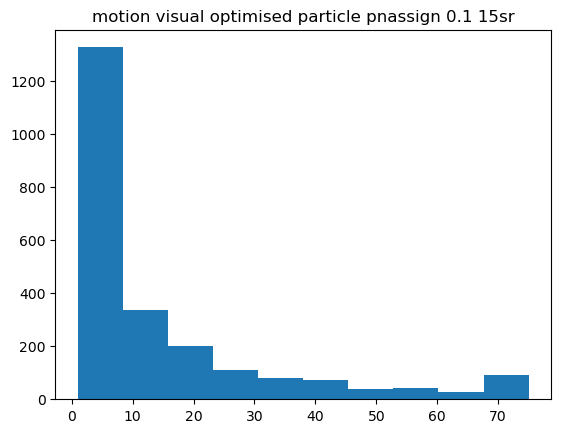

In [182]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.1 15sr')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 16.54203437064561
n<10 1170


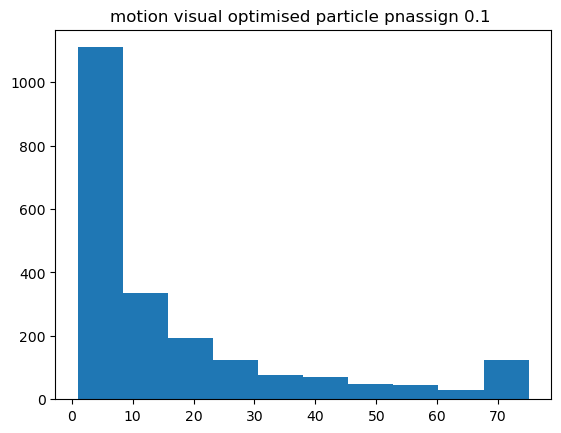

In [180]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.1 ')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 16.276430205949655
n<10 1209


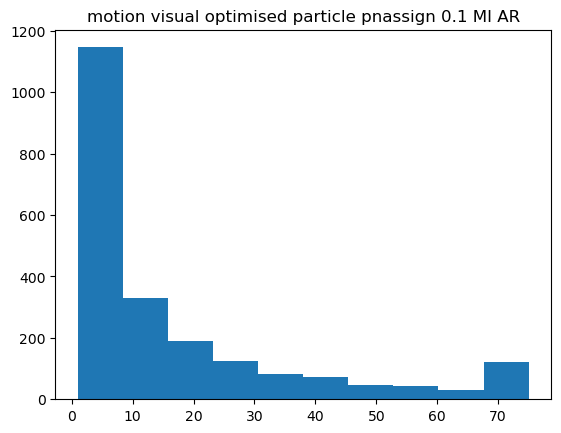

In [177]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.1 MI AR')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 16.06362007168459
n<10 1246


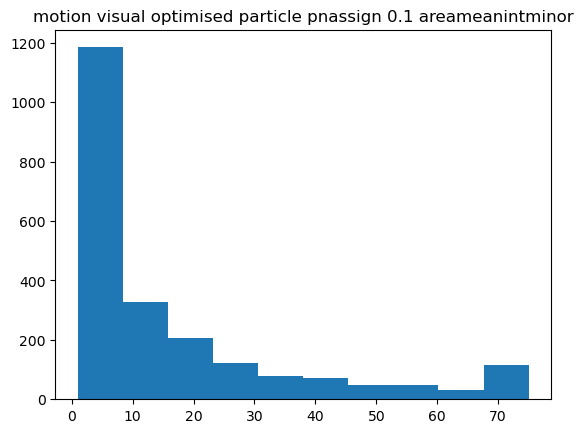

In [167]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.1 areameanintminor')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 16.050581915846017
n<10 1246


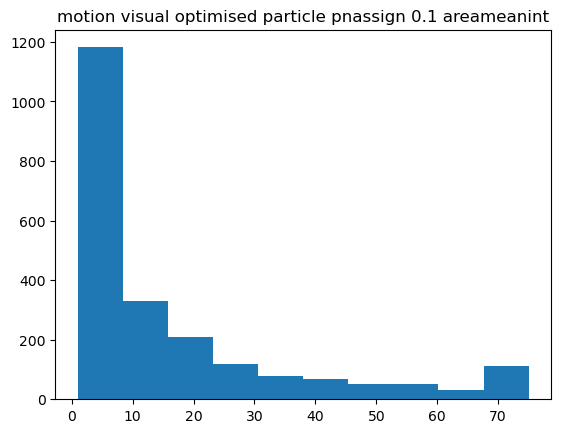

In [162]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.1 areameanint')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 15.823555359505955
n<10 1265


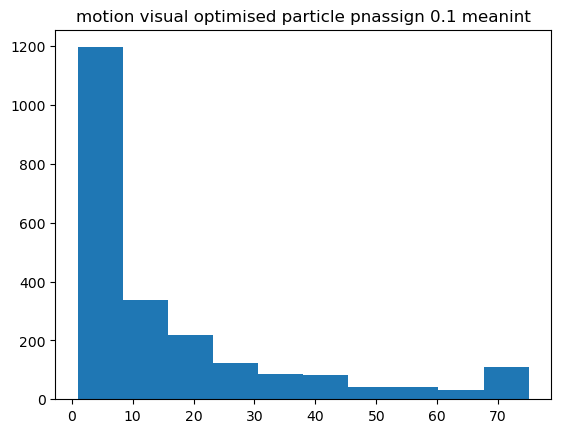

In [150]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.1 meanint')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 16.54203437064561
n<10 1170


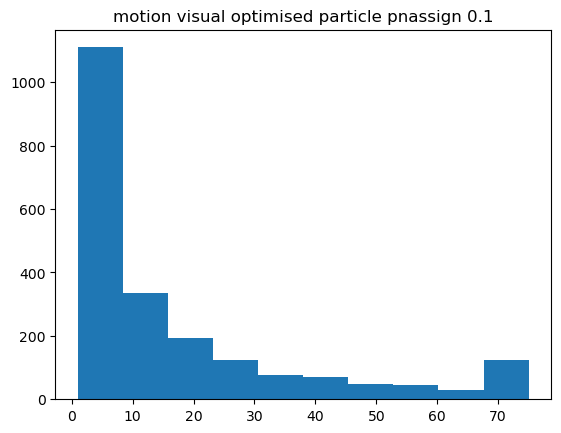

In [123]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.1')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 1.0
n<10 31239


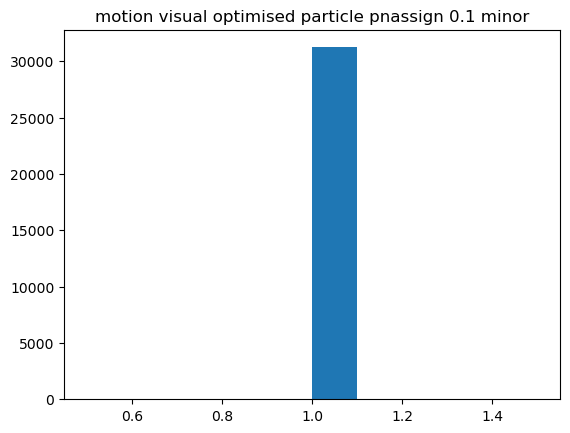

In [159]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.1 minor')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 1.0
n<10 31239


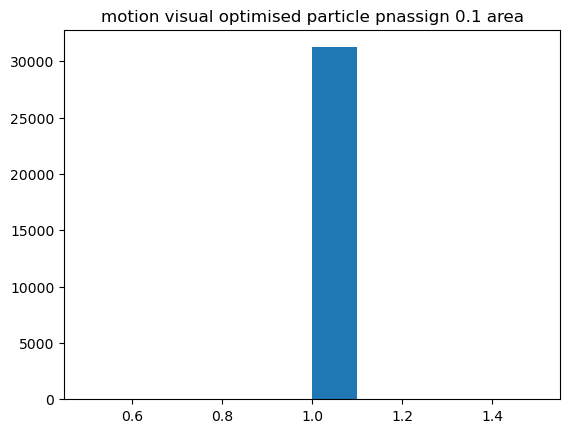

In [153]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.1 area')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 1.0
n<10 31165


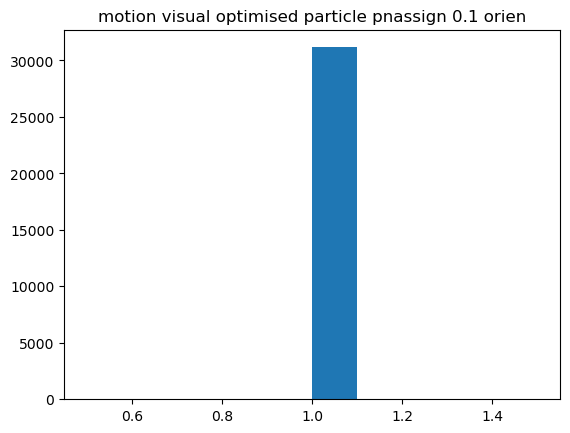

In [136]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.1 orien')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 16.217509025270758
n<10 1230


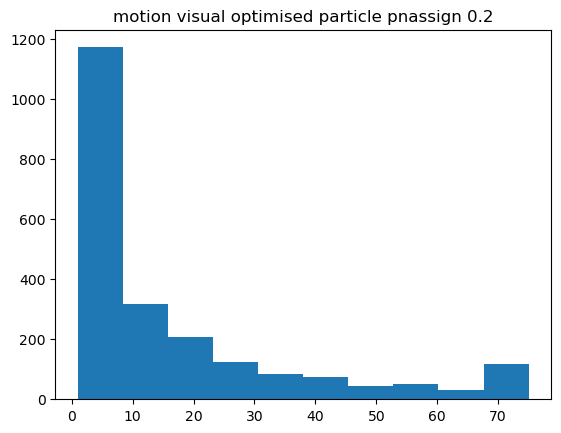

In [130]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.2')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 16.00087989441267
n<10 1263


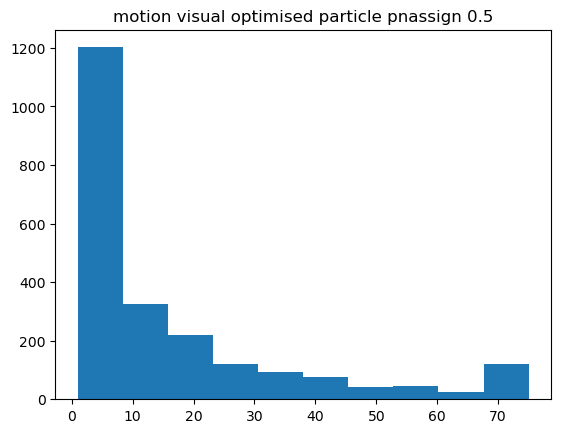

In [127]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.5')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 16.766346153846154
n<10 1119


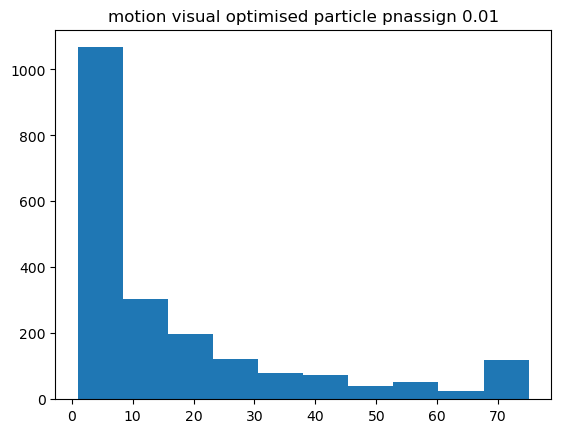

In [94]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.01')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 18.474252084355076
n<10 1012


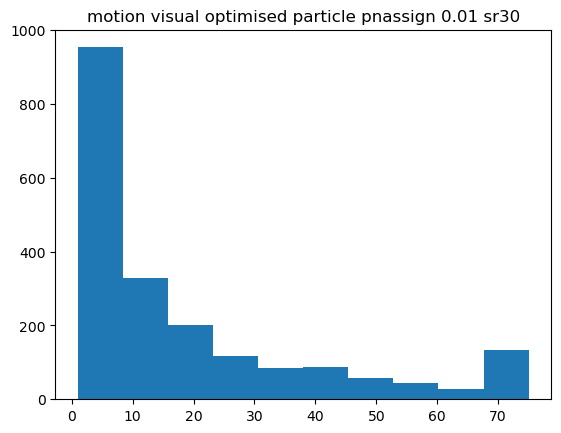

In [109]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.01 sr30')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 19.540796019900498
n<10 935


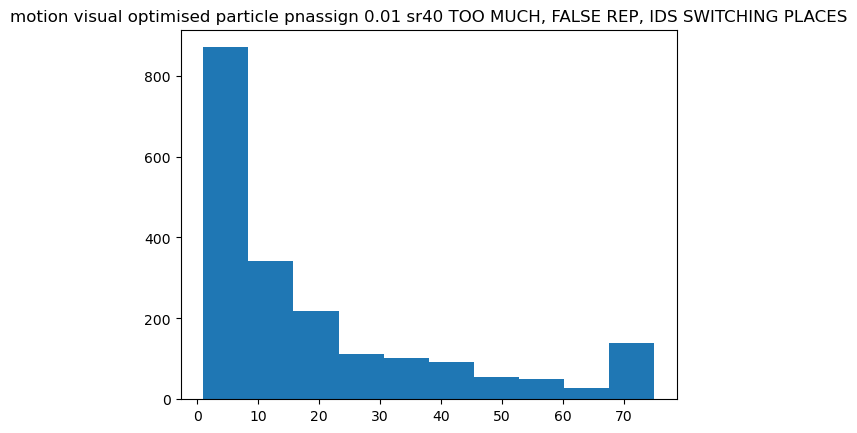

In [114]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.01 sr40 TOO MUCH, FALSE REP, IDS SWITCHING PLACES')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 18.060425953442298
n<10 1015


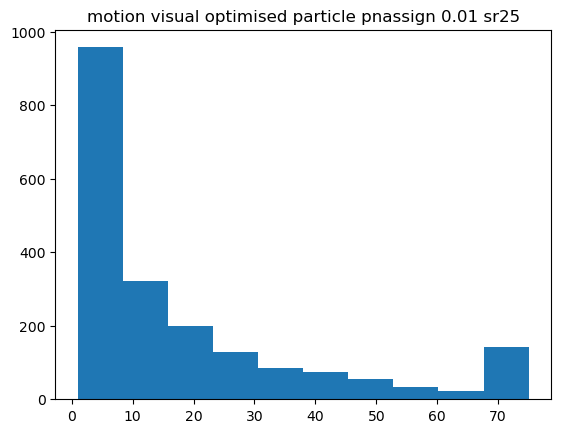

In [106]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.01 sr25')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 14.27336860670194
n<10 1361


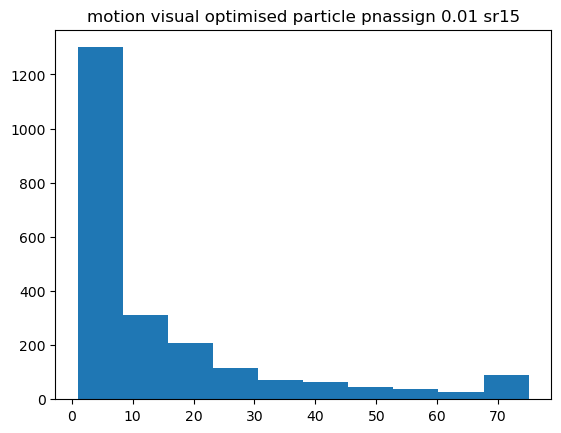

In [103]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.01 sr15')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 10.262746557499069
n<10 1839


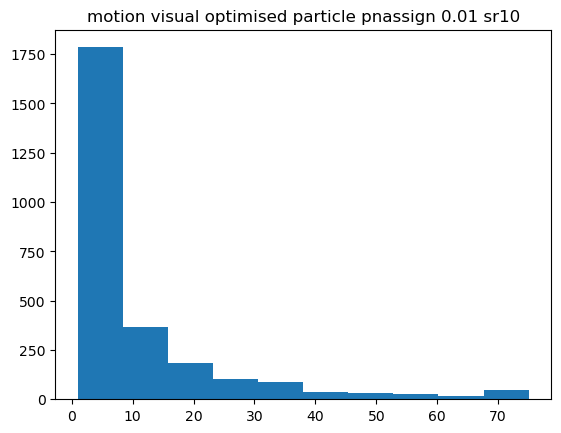

In [100]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.01 sr10')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 11.96774193548387
n<10 1800


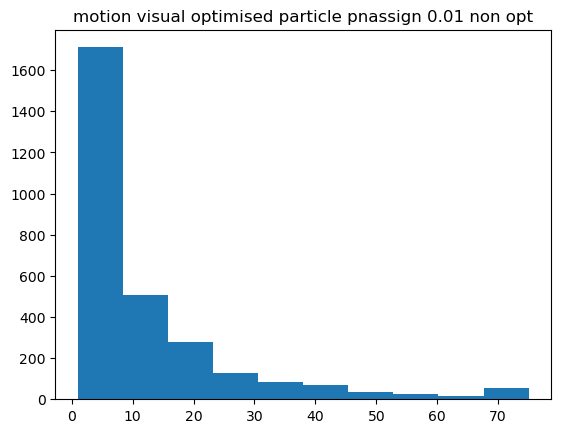

In [97]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.01 non opt')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 16.54203437064561
n<10 1170


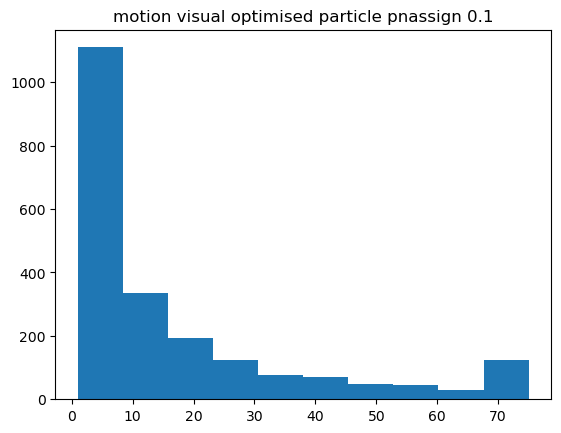

In [78]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle pnassign 0.1')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 16.65097087378641
n<10 1134


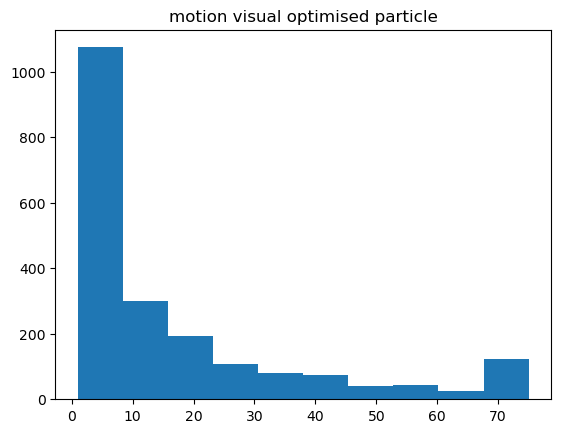

In [88]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised particle')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 12.733742331288344
n<10 1560


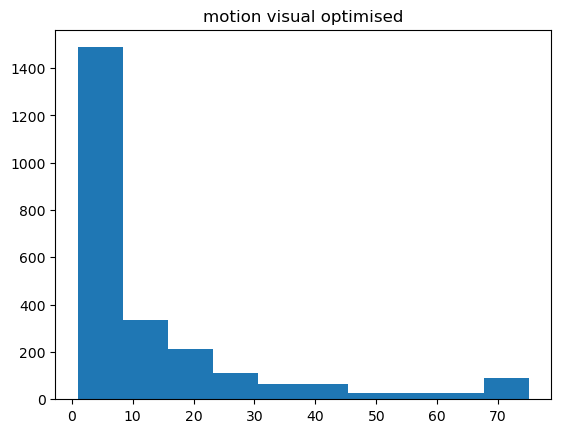

In [69]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion visual optimised')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

mean: 11.456252095206167
n<10 1988


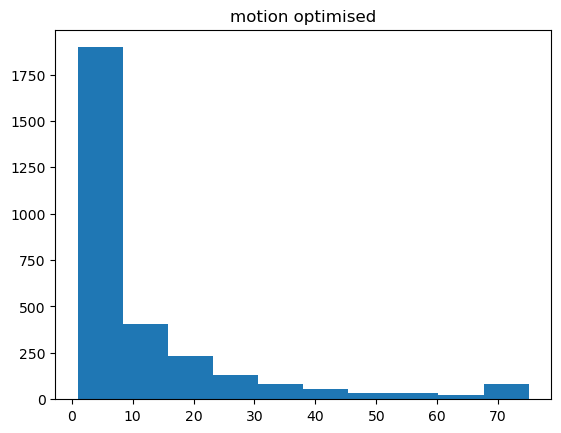

In [66]:
plt.hist([len(track) for track in re_tracks])
plt.title('motion optimised')
print('mean:', np.mean([len(track) for track in re_tracks]))
print('n<10', len([track for track in re_tracks if len(track)<10]))

9.3805363061163


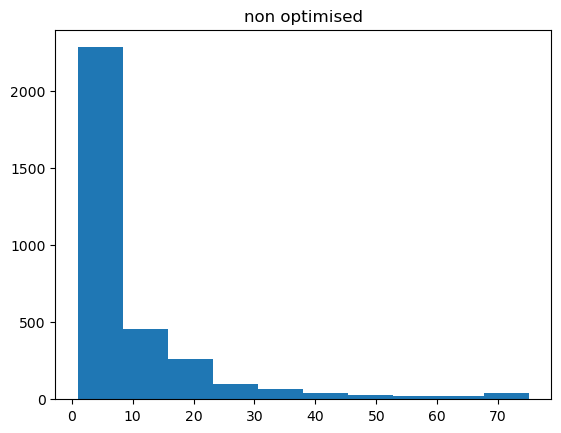

In [53]:
plt.hist([len(track) for track in re_tracks])
plt.title('non optimised')
print(np.mean([len(track) for track in re_tracks]))